In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


df_cleaned = pd.read_csv('/Users/talhakimi/data-science-flights-project/Data Procces/Cleaned_AllFlightsData.csv')
google_df = df_cleaned[df_cleaned["Website"] == "Google flights"].copy()
kayak_df = df_cleaned[df_cleaned["Website"] == "Kayak Flights"].copy()

# Merge Google Flights and Kayak data based on flight details
merged_df = pd.merge(
    google_df, kayak_df,
    on=["Airline", "Origin", "Destination", "Departure date", "Departure Airport", "Arrival Airport"],
    suffixes=("_google", "_kayak")
)

# Compute Price Difference
merged_df["Price Difference"] = merged_df["Price_google"] - merged_df["Price_kayak"]

# Select Relevant Features for Prediction
features = ["TTT_google", "LOS_google", "Layover_google", "Stops_google", "Duration_google"]
target = "Price Difference"

# Convert date columns to datetime
merged_df["Snapshot date_google"] = pd.to_datetime(merged_df["Snapshot date_google"])
merged_df["Departure date"] = pd.to_datetime(merged_df["Departure date"])

# Feature Engineering
merged_df["Departure Day"] = merged_df["Departure date"].dt.dayofweek  # 0=Monday, 6=Sunday
merged_df["Days Before Departure"] = (merged_df["Departure date"] - merged_df["Snapshot date_google"]).dt.days
merged_df["Departure Month"] = merged_df["Departure date"].dt.month
merged_df["Near Month End"] = (merged_df["Departure date"].dt.day >= 25).astype(int)
merged_df["Holiday Season"] = merged_df["Departure Month"].apply(lambda x: 1 if x in [6, 7, 8, 12] else 0)

# Add New Features
features += ["Departure Day", "Days Before Departure", "Departure Month", "Near Month End", "Holiday Season"]

# Drop NA values (if any)
merged_df = merged_df.dropna()

# Split into Train (70%) and Test (30%)
X = merged_df[features]
y = merged_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Proceed to model training
merged_df.head()


,Website_google,Snapshot date_google,Airline,Price_google,TTT_google,LOS_google,Origin,Destination,Departure date,Departure Airport,...,Stops_kayak,Return date_kayak,Arrival Time_kayak,Duration_kayak,Price Difference,Departure Day,Days Before Departure,Departure Month,Near Month End,Holiday Season
0,Google flights,2025-03-03,easyJet,101,2,1,London,Paris,2025-03-05,LTN,...,0,2025-03-10,21:00:00,1.33,-16,2,2,3,0,0
1,Google flights,2025-03-03,easyJet,101,2,1,London,Paris,2025-03-05,LTN,...,0,2025-03-10,21:00:00,1.33,-18,2,2,3,0,0
2,Google flights,2025-03-03,easyJet,101,2,1,London,Paris,2025-03-05,LTN,...,0,2025-03-10,17:00:00,1.33,-21,2,2,3,0,0
3,Google flights,2025-03-03,easyJet,101,2,1,London,Paris,2025-03-05,LTN,...,0,2025-03-10,17:00:00,1.33,-23,2,2,3,0,0
4,Google flights,2025-03-03,easyJet,101,2,1,London,Paris,2025-03-05,LTN,...,0,2025-03-10,09:25:00,1.33,-51,2,2,3,0,0


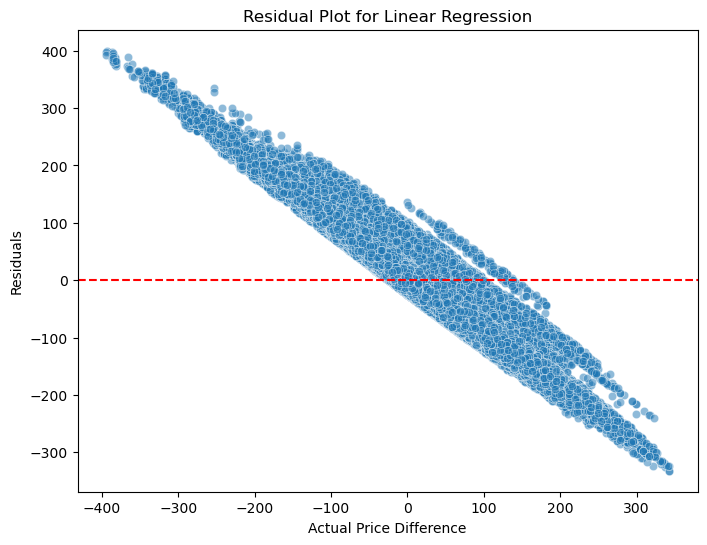

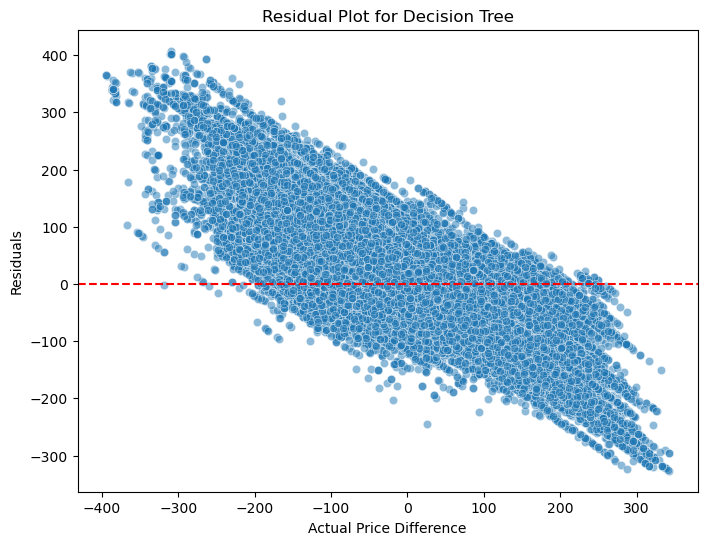

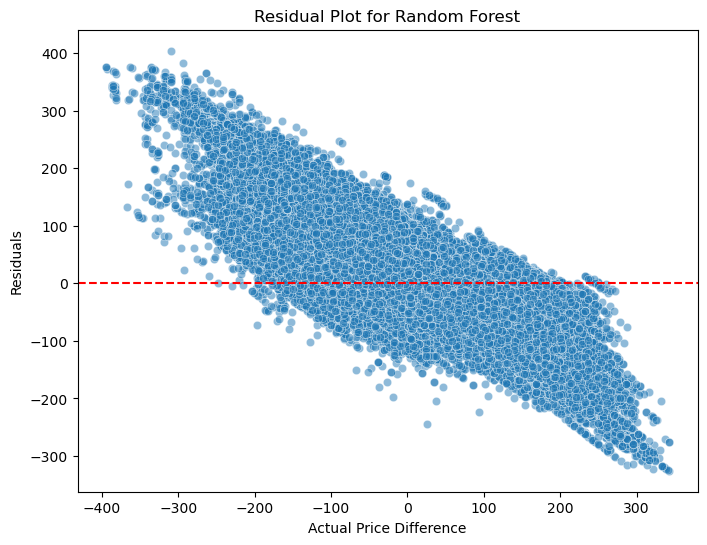

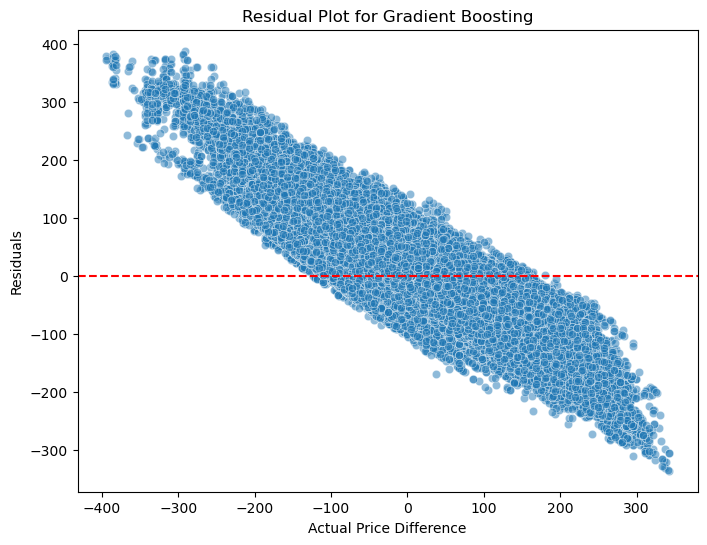

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

# Define Regression Models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "SVR": SVR(kernel="rbf", C=100, gamma=0.1)
}

# Train and Evaluate Models
results = []
for name, model in models.items():
    pipeline = Pipeline([
        ("regressor", model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    # Compute Error Metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    rmse = np.sqrt(mse)

    results.append([name, r2_train, r2_test, mae, mse, rmse])

    # Residual Plot
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=y_test, y=y_test_pred - y_test, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Actual Price Difference")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot for {name}")
    plt.show()

# Display Results
results_df = pd.DataFrame(results, columns=["Model", "R2 Train", "R2 Test", "MAE", "MSE", "RMSE"])
print("\nModel Performance Metrics:\n", results_df)

# Identify Best Model
best_model_name = results_df.sort_values("R2 Test", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

# Feature Importance Analysis
pipeline = Pipeline([
    ("regressor", best_model)
])
pipeline.fit(X_train, y_train)

# Model-based Feature Importance
if hasattr(best_model, "feature_importances_"):
    feature_importance = best_model.feature_importances_
    importance_df = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importance}).sort_values(by="Importance", ascending=False)

    # Plot Feature Importance
    plt.figure(figsize=(12,6))
    sns.barplot(data=importance_df[:15], x="Importance", y="Feature")
    plt.title(f"Feature Importance - {best_model_name}")
    plt.show()

# Permutation Feature Importance (Black-Box Approach)
perm_importance = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

# Plot Permutation Importance
plt.figure(figsize=(12,6))
sns.barplot(data=perm_importance_df[:15], x="Importance", y="Feature")
plt.title("Permutation Feature Importance (Black Box)")
plt.show()

# Final Insights
print(f"""
**Final Insights:**
- The best model was **{best_model_name}**, achieving the highest R2 test score.
- Feature importance analysis revealed which factors influence price differences between Google Flights and Kayak.
- The **residual plots** indicate that some extreme price differences are harder to predict accurately.
- SVR struggled due to the complexity of the data, while **Random Forest and Gradient Boosting** performed well.

This analysis provides insights into how price differences between flight websites behave.
""")
